In [198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def get_differential_filter():
    filter_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    filter_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
    return filter_x, filter_y

In [199]:
def filter_image(im, filter):
    im_filtered = np.empty_like(im, dtype=np.float64)
    im = np.pad(im, pad_width=((1,1),(1,1)), mode='constant')
    
    for y in range(im.shape[0]-2):
        for x in range(im.shape[1]-2):
            im_filtered[y,x] = np.sum(im[y:y+3, x:x+3] * filter)
        
    return im_filtered

In [200]:
def get_gradient(im_dx, im_dy):
    grad_mag = np.empty_like(im_dx, dtype=np.float64)
    grad_angle = np.empty_like(im_dx, dtype=np.float64)
    
    for y in range(im_dx.shape[0]):
        for x in range(im_dx.shape[1]):
            grad_mag[y,x] = np.sqrt(np.power(im_dx[y,x],2) + np.power(im_dy[y,x],2))
            angle = np.arctan(im_dx[y,x]/(im_dy[y,x]+0.00000001))
            if angle < 0 :
                grad_angle[y,x] = angle + np.pi
            else :
                grad_angle[y,x] = angle
                
    
    return grad_mag, grad_angle

In [201]:
def build_histogram(grad_mag, grad_angle, cell_size):
    m = int(grad_mag.shape[0]/cell_size)
    n = int(grad_mag.shape[1]/cell_size)
    ori_histo = np.zeros((m, n, 6))
    
    hist_rad = np.radians([15,45,75,105,135,165])
    interval_rad = np.radians(30)
    
    for y_cell in range(m):
        for x_cell in range(n):
            
            for y in range(cell_size*y_cell, cell_size*(y_cell+1)):
                for x in range(cell_size*x_cell, cell_size*(x_cell+1)):
                    
                    if grad_angle[y,x] < hist_rad[0] or grad_angle[y,x] >= hist_rad[5] :
                        ori_histo[y_cell, x_cell, 0] += grad_mag[y,x]
                  
                    else:
                        hist = int((grad_angle[y,x] + hist_rad[0])/interval_rad)
                        ori_histo[y_cell, x_cell, hist] += grad_mag[y,x]
                    
    return ori_histo

In [202]:
def get_block_descriptor(ori_histo, block_size):
    
    m = ori_histo.shape[0] - block_size + 1
    n = ori_histo.shape[1] - block_size + 1
    ori_histo_normalized = np.zeros((m, n, 6*np.power(block_size, 2)))
    
    for y_blk in range(m):
        for x_blk in range(n):
            block_vec = np.concatenate(
                (ori_histo[y_blk, x_blk, :], ori_histo[y_blk, x_blk+1, :], ori_histo[y_blk+1, x_blk, :], ori_histo[y_blk+1, x_blk+1, :])
            )
            l2_norm = np.sqrt(np.square(block_vec).sum() + 0.000001)
            block_vec = block_vec/l2_norm
            ori_histo_normalized[y_blk, x_blk] = block_vec
            
    return ori_histo_normalized

In [203]:
def visualize_hog(im, hog, cell_size, block_size):
    num_bins = 6
    max_len = 7  # control sum of segment lengths for visualized histogram bin of each block
    im_h, im_w = im.shape
    num_cell_h, num_cell_w = int(im_h / cell_size), int(im_w / cell_size)
    num_blocks_h, num_blocks_w = num_cell_h - block_size + 1, num_cell_w - block_size + 1
    histo_normalized = hog.reshape((num_blocks_h, num_blocks_w, block_size**2, num_bins))
    histo_normalized_vis = np.sum(histo_normalized**2, axis=2) * max_len  # num_blocks_h x num_blocks_w x num_bins
    angles = np.arange(0, np.pi, np.pi/num_bins)
    mesh_x, mesh_y = np.meshgrid(np.r_[cell_size: cell_size*num_cell_w: cell_size], np.r_[cell_size: cell_size*num_cell_h: cell_size])
    mesh_u = histo_normalized_vis * np.sin(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    mesh_v = histo_normalized_vis * -np.cos(angles).reshape((1, 1, num_bins))  # expand to same dims as histo_normalized
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    for i in range(num_bins):
        plt.quiver(mesh_x - 0.5 * mesh_u[:, :, i], mesh_y - 0.5 * mesh_v[:, :, i], mesh_u[:, :, i], mesh_v[:, :, i],
                   color='red', headaxislength=0, headlength=0, scale_units='xy', scale=1, width=0.002, angles='xy')
    # plt.show()
    plt.savefig('hog.png')


In [204]:
def extract_hog(im, visualize=False, cell_size=8, block_size=2):
    im = im.astype(np.float64)
    min_im = np.min(im)
    max_im = np.max(im)
    #normalization to range[0,1]
    
    #im = im - min_im
    #im = im/(max_im - min_im)
    
    #im = im / max_im
    
    im = im / 256
    
    #get filtered image
    filter_x, filter_y = get_differential_filter()
    im_dx = filter_image(im, filter_x)
    im_dy = filter_image(im, filter_y)
    
    #get gradients, normalized histogram, and return concatenated hog vector
    grad_mag, grad_angle = get_gradient(im_dx, im_dy)
    ori_histo = build_histogram(grad_mag, grad_angle, cell_size)
    ori_histo_normalized = get_block_descriptor(ori_histo, block_size)
    if visualize:
        return ori_histo_normalized
    
    hog = ori_histo_normalized.reshape(-1)    
    return hog




In [205]:
def face_recognition(I_target, I_template):
    threshold = 0.3

    target_h, target_w = I_target.shape
    target_hog = extract_hog(I_target, visualize=True, cell_size=8, block_size=2)
    target_blocks_h, target_blocks_w = target_hog.shape[0], target_hog.shape[1]
    
    tem_h, tem_w = I_template.shape
    tem_cell_h, tem_cell_w = int(tem_h / 8), int(tem_w / 8)
    tem_blocks_h, tem_blocks_w = tem_cell_h - 1, tem_cell_w - 1
    tem_hog = extract_hog(I_template, cell_size=8, block_size=2)
    norm_tem_hog = tem_hog - np.mean(tem_hog)
    
    temp_list = []
    max_score = 0
    for top_y in range(target_blocks_h-tem_blocks_h):
        for left_x in range(target_blocks_w-tem_blocks_w):
            right_x = left_x + tem_blocks_w
            bottom_y = top_y + tem_blocks_h
            
            box = target_hog[top_y:bottom_y, left_x:right_x, : ].reshape(-1)
            norm_box = box - np.mean(box)
            score = (np.dot(norm_box, norm_tem_hog)/(np.linalg.norm(norm_box, ord=2)*np.linalg.norm(norm_tem_hog, ord=2)))
            
            if score >= threshold :
                temp_list.append([8*left_x, 8*top_y, score])
            max_score = max(score,max_score)
    
    bb_list = np.array(temp_list)
    final_list = []
    
    
    while bb_list.size > 0 :
        best_x, best_y, best_score, bb_list = non_maximum_suppression(bb_list, tem_h, tem_h)
        final_list.append([best_x, best_y, best_score])
    
    bounding_boxes = np.array(final_list)
    return bounding_boxes

In [206]:
def non_maximum_suppression(bb_list, h_size, w_size):
    bb_list = bb_list[bb_list[:,2].argsort()[::-1]]
    x, y, score = bb_list[0, 0], bb_list[0, 1], bb_list[0, 2]
    bb_list = np.delete(bb_list, 0, 0)
    
    drop_idx = []
    
    for i in range(bb_list.shape[0]):
        IOU = get_IOU(x, y, bb_list[i, 0], bb_list[i, 1], h_size, w_size)
        if IOU >= 0.3:
            drop_idx.append(i)
            
    bb_list = np.delete(bb_list, drop_idx, 0)
    
    return x, y, score, bb_list

In [207]:
def get_IOU(x1, y1, x2, y2, h_size, w_size):
    left_inter = max(x1, x2)
    right_inter = min(x1+w_size, x2+w_size)
    top_inter = max(y1, y2)
    bottom_inter = min(y1+h_size, y2+h_size)
    
    width_inter = right_inter - left_inter
    height_inter = bottom_inter - top_inter
    #print("x1 {}  y1 {}  x2 {}  y2 {}  w {}  h {}".format(x1, y1, x2, y2, width_inter, height_inter) )
    if width_inter <= 0 or height_inter <= 0 :
        return 0
    
    area_inter = width_inter * height_inter
    total_area = 2*h_size*w_size - area_inter
    #print("iou {}".format(area_inter/total_area))
    
    return area_inter/total_area

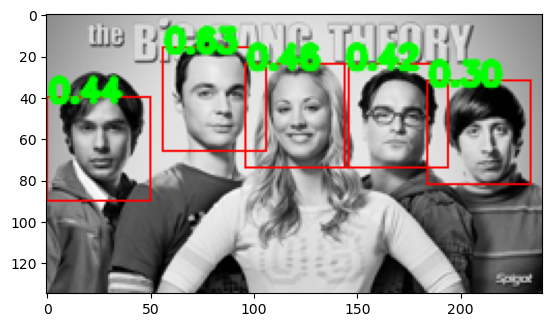

In [208]:
im = cv2.imread('cameraman.tif', 0)
hog = extract_hog(im, visualize=False)

I_target= cv2.imread('target.png', 0) # MxN image

I_template = cv2.imread('template.png', 0) # mxn  face template

bounding_boxes = face_recognition(I_target, I_template)

I_target_c= cv2.imread('target.png') # MxN image (just for visualization)
    
visualize_face_detection(I_target_c, bounding_boxes, I_template.shape[0]) # visualization code


In [56]:
def visualize_face_detection(I_target, bounding_boxes, box_size):

    hh,ww,cc=I_target.shape

    fimg=I_target.copy()
    for ii in range(bounding_boxes.shape[0]):

        x1 = bounding_boxes[ii,0]
        x2 = bounding_boxes[ii, 0] + box_size 
        y1 = bounding_boxes[ii, 1]
        y2 = bounding_boxes[ii, 1] + box_size

        if x1<0:
            x1=0
        if x1>ww-1:
            x1=ww-1
        if x2<0:
            x2=0
        if x2>ww-1:
            x2=ww-1
        if y1<0:
            y1=0
        if y1>hh-1:
            y1=hh-1
        if y2<0:
            y2=0
        if y2>hh-1:
            y2=hh-1
        fimg = cv2.rectangle(fimg, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 1)
        cv2.putText(fimg, "%.2f"%bounding_boxes[ii,2], (int(x1)+1, int(y1)+2), cv2.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(3)
    plt.imshow(fimg, vmin=0, vmax=1)
    plt.imsave('result_face_detection.png', fimg, vmin=0, vmax=1)
    plt.show()

In [211]:
!python HOG_ver1.py

Figure(640x480)
